#Распознаем писателей с помощью простой Dense сети без фильтрации данных

**импорт библиотек**


In [1]:
from google.colab import files # работа с файлами
import numpy as np # работа с массивами numpy
import pandas as pd # работа с датафреймами
import matplotlib.pyplot as plt # вывод графиков
import os   # файловая система
import glob # файловая система
%matplotlib inline

from tensorflow.keras import utils # перевод значений в категориальные
from tensorflow.keras.models import Sequential # последовательная модель сети
from tensorflow.keras.optimizers import Adam # оптимайзер Adam
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation # слои сети
from tensorflow.keras.preprocessing.text import Tokenizer # преобразование текстов в последовательности
from tensorflow.keras.preprocessing.sequence import pad_sequences # работа с последовательностями
from tensorflow.keras.callbacks import ModelCheckpoint # для сохранения весов на эпохах

from sklearn.preprocessing import LabelEncoder # кодирование текстовых меток
from sklearn.model_selection import train_test_split # разделение на выборки
from google.colab import drive # работа с гугл диском
import random # для генерации случайных чисел
#import time # работа с системным временем
#import seaborn as sns # вывод графики
#sns.set_style('darkgrid') # стиль графиков

**загрузка данных**

In [2]:
# удаляем папку /content/texts если существует
!rm -R /content/texts
# загрузим в окружение свои файлы для распознавания 
!wget 'http://m.ric.media/nu/Тексты писателей.zip'
# распаковываем тексты в папку /content/texts
!unzip -q -o 'Тексты писателей.zip' -d '/content/texts'
# просмотр содержимого каталогов
!ls
!ls '/content/texts'

rm: cannot remove '/content/texts': No such file or directory
--2021-11-21 19:44:44--  http://m.ric.media/nu/%D0%A2%D0%B5%D0%BA%D1%81%D1%82%D1%8B%20%D0%BF%D0%B8%D1%81%D0%B0%D1%82%D0%B5%D0%BB%D0%B5%D0%B9.zip
Resolving m.ric.media (m.ric.media)... 176.213.150.19
Connecting to m.ric.media (m.ric.media)|176.213.150.19|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7548513 (7.2M) [application/zip]
Saving to: ‘Тексты писателей.zip’

Тексты писателей.zi 100%[===================>]   7.20M  2.95MB/s    in 2.4s    

2021-11-21 19:44:47 (2.95 MB/s) - ‘Тексты писателей.zip’ saved [7548513/7548513]

 sample_data   texts  'Тексты писателей.zip'
'(Булгаков) Обучающая_5 вместе.txt'
'(Булгаков) Тестовая_2 вместе.txt'
'(Клиффорд_Саймак) Обучающая_5 вместе.txt'
'(Клиффорд_Саймак) Тестовая_2 вместе.txt'
'(Макс Фрай) Обучающая_5 вместе.txt'
'(Макс Фрай) Тестовая_2 вместе.txt'
'(О. Генри) Обучающая_50 вместе.txt'
'(О. Генри) Тестовая_20 вместе.txt'
'(Рэй Брэдберри) Обучающая_22 вме

In [3]:
# функция чтения файла с текстом
def readText(filename):
  with open(filename, 'r') as f:  # открыть файл
    text = f.read()               # прочитать в переменную text
  text = text.replace('\n', '')   # заменим переносы строк на пробелы
  return text

# объявляем классы
className = ['Брэдберри', 'Булгаков', 'О. Генри', 'Саймак', 'Стругацкие', 'Фрай']
# выводим количество классов
print('Количество классов:', len(className))

Количество классов: 6


In [4]:
trainText = [] # обучающая выборка списком классов (все тексты)
testText  = [] # тестовая выборка списокм классов (все тексты)
for cl in className: # проходим по именам классов
  # перебираем все обучающие этого класса
  for fname in glob.glob('/content/texts/*'+cl+'*Обучающая*.txt'):
    trainText.append(readText(fname)) # читаем очередной файл Писатель+Обучающая
    print('Обучающая выборка:', fname)
  # перебираем все тестовые этого класса
  for fname in glob.glob('/content/texts/*'+cl+'*Тестовая*.txt'):
    testText.append(readText(fname)) # читаем очередной файл Писатель+Тестовая
    print('Тестовая выборка:', fname, '\n')

# выводим количество классов
print('Загружено файлов в обучающей выборке:', len(trainText))
print('Загружено файлов в тестовой выборке:', len(testText))

Обучающая выборка: /content/texts/(Рэй Брэдберри) Обучающая_22 вместе.txt
Тестовая выборка: /content/texts/(Рэй Брэдберри) Тестовая_8 вместе.txt 

Обучающая выборка: /content/texts/(Булгаков) Обучающая_5 вместе.txt
Тестовая выборка: /content/texts/(Булгаков) Тестовая_2 вместе.txt 

Обучающая выборка: /content/texts/(О. Генри) Обучающая_50 вместе.txt
Тестовая выборка: /content/texts/(О. Генри) Тестовая_20 вместе.txt 

Обучающая выборка: /content/texts/(Клиффорд_Саймак) Обучающая_5 вместе.txt
Тестовая выборка: /content/texts/(Клиффорд_Саймак) Тестовая_2 вместе.txt 

Обучающая выборка: /content/texts/(Стругацкие) Обучающая_5 вместе.txt
Тестовая выборка: /content/texts/(Стругацкие) Тестовая_2 вместе.txt 

Обучающая выборка: /content/texts/(Макс Фрай) Обучающая_5 вместе.txt
Тестовая выборка: /content/texts/(Макс Фрай) Тестовая_2 вместе.txt 

Загружено файлов в обучающей выборке: 6
Загружено файлов в тестовой выборке: 6


### Функции формирования выборок

In [5]:
# напишем функцию возвращающую два набора X и Y из одного (возвращаем окна размером xLen с шагом step)
def split_word_indexes(wordIndexes, xLen, step):
  '''
  split_word_indexes - функция создания выборок X и Y из общего списка с текстами
  вход:
    wordIndexes - общий список (один класс на элемент, класс соотв. индексу элемента)
    xLen - длина окна
    step - шаг смещения окна
  выход:
    x - обучающая выборка
    y - тестовая выборка
  '''
  # инициализируем выборки
  x = [] 
  y = []
  wordIndexesLen = len(wordIndexes) # количество классов
  for classInd, wordsList in enumerate(wordIndexes): # проходим по классам
    StartPos = 0 # для каждого класса окно возвращаем на стартовую позицию
    wordsLen = len(wordsList) # количество индексов(слов) в очередном классе
    while StartPos + xLen <= wordsLen: # пока позиция окна+длина окна <= длине всего списка слов
      x.append(wordsList[StartPos:StartPos+xLen])               # добавим содержимое окна в выборку
      y.append(utils.to_categorical(classInd, wordIndexesLen))  # добавим номер класса в выборку в формате One-Hot Encoding
      StartPos += step # сдвигаем окно дальше на размер шага
  x = pad_sequences(x, xLen) # выравниваем обучающую выборку так чтобы последнее окно было равно требуемому xLen 
  x = np.array(x) # переводим в формат numpy массива
  y = np.array(y) # переводим в формат numpy массива
  return (x, y)

### Создание обучающей и проверочной выборок

In [6]:
# задаем параметры
maxWordsCount = 25000 # размер словаря # 20000
xLen = 2600 # размер окна в словах для распознавания # 1000
step = 150  # шаг смещения при формировании окна # 100
nClasses = len(testText) # количество классов

# создаем токенайзер и обучаем его
tokenizer = Tokenizer(num_words=maxWordsCount, # количество слов для словаря
                      filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', # фильтр текста
                      lower=True, # нижний регистр
                      split=' ', # разделить пробелом
                      oov_token='unknown', # обозначим слова вне словаря
                      char_level=False # токенизируем по словам
                      )
tokenizer.fit_on_texts(trainText) # обучаем и проходим по обучающей выборке (список текстов по классам)  

# преобразуем обучающую и тестовую выборки в последовательности индексов по обученому токенайзеру и его частотному словарю
trainWordIndexes = tokenizer.texts_to_sequences(trainText)
testWordIndexes = tokenizer.texts_to_sequences(testText)

# формируем обучающую и проверочную выборки
xTrain, yTrain = split_word_indexes(trainWordIndexes, xLen, step) # формируем обучающую выборку
xTest,  yTest  = split_word_indexes(testWordIndexes, xLen, step)  # формируем тестовую выборку

# получим с помощью токенайзера вектора 0 и 1 для Bag of Words (последовательности в матрицу)
xTrain01 = tokenizer.sequences_to_matrix(xTrain.tolist())
xTest01  = tokenizer.sequences_to_matrix(xTest.tolist())

In [7]:
# выведем количество примеров на класс в обучающей выборке
y_Train = np.argmax(yTrain, axis=1) # получим список меток без One-Hot Encoding
for i in range(nClasses): # пройдем количеством классов (писателей)
  Labels = np.where(y_Train==i)[0] # получим индексы примеров класса i на каждом шаге
  print(className[i], ':', len(Labels))

Брэдберри : 1412
Булгаков : 1726
О. Генри : 1054
Саймак : 1659
Стругацкие : 2069
Фрай : 3773


### Создание и обучение модели


Обучение (maxWordsCount=25000, xLen=2600, step=150):

Epoch 1/10
92/92 [==============================] - 4s 18ms/step - loss: 0.4746 - accuracy: 0.8874 - val_loss: 0.3729 - val_accuracy: 0.9547
Epoch 2/10
92/92 [==============================] - 1s 13ms/step - loss: 0.1471 - accuracy: 0.9812 - val_loss: 0.3401 - val_accuracy: 0.9495
Epoch 3/10
92/92 [==============================] - 1s 13ms/step - loss: 0.0863 - accuracy: 0.9897 - val_loss: 0.3028 - val_accuracy: 0.9558
Epoch 4/10
92/92 [==============================] - 1s 14ms/step - loss: 0.0615 - accuracy: 0.9925 - val_loss: 0.2818 - val_accuracy: 0.9522
Epoch 5/10
92/92 [==============================] - 1s 14ms/step - loss: 0.0473 - accuracy: 0.9937 - val_loss: 0.2492 - val_accuracy: 0.9652
Epoch 6/10
92/92 [==============================] - 1s 13ms/step - loss: 0.0385 - accuracy: 0.9958 - val_loss: 0.2236 - val_accuracy: 0.9627
Epoch 7/10
92/92 [==============================] - 1s 14ms/step - loss: 0.0348 - accuracy: 0.9947 

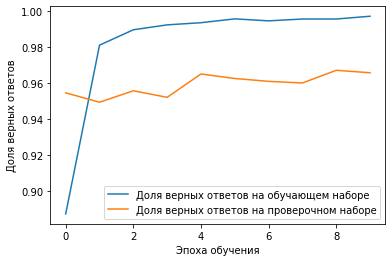

In [8]:
# создание нейросети (последовательная модель)
model01 = Sequential()

# добавляем слои
model01.add(Dense(300, input_dim=maxWordsCount, activation='relu')) # полносвязный слой
model01.add(Dropout(0.9)) # слой регуляризации

# model01.add(Dense(200, activation='relu')) # полносвязный слой
# model01.add(BatchNormalization()) # слой пакетной нормализации
# model01.add(Dense(100, activation='relu')) # полносвязный слой
# model01.add(Dropout(0.9)) # слой регуляризации

# model01.add(BatchNormalization()) # слой пакетной нормализации
# model01.add(Dense(300, activation='relu')) # полносвязный слой
# model01.add(Dropout(0.4)) # слой регуляризации

model01.add(BatchNormalization()) # слой пакетной нормализации
model01.add(Dense(6, activation='softmax')) # полносвязный слой

# компилируем
model01.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

# отобразим данные модели
#model01.summary()

# вызов callback для сохранения весов каждой эпохи
mc = ModelCheckpoint('weights{epoch:08d}.h5', save_weights_only=True)

# обучаем модель
print(f'\nОбучение (maxWordsCount={maxWordsCount}, xLen={xLen}, step={step}):\n')
history = model01.fit(xTrain01,
                      yTrain,
                      epochs=10,
                      batch_size=128,
                      validation_data=(xTest01, yTest),
                      callbacks=[mc])

# отображаем график точности обучения
plt.plot(history.history['accuracy'], label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [9]:
# загрузим веса эпохи, которая показала лучший результат
#model01.load_weights('weights00000004.h5')

In [10]:
# сохраним предварительные результаты
model01.save('writers.h5')


Дообучение (уменьшим шаг обучения)


In [11]:
# компилируем
model01.compile(loss='categorical_crossentropy',
                optimizer=Adam(learning_rate=0.0001),
                metrics=['accuracy'])

# вызов callback для сохранения весов каждой эпохи
mc = ModelCheckpoint('weights{epoch:08d}.h5', save_weights_only=True)

# обучаем модель
print(f'\nОбучение (maxWordsCount={maxWordsCount}, xLen={xLen}, step={step}):\n')
history = model01.fit(xTrain01,
                      yTrain,
                      epochs=10,
                      batch_size=128,
                      validation_data=(xTest01, yTest),
                      callbacks=[mc])



Обучение (maxWordsCount=25000, xLen=2600, step=150):

Epoch 1/10
92/92 [==============================] - 2s 18ms/step - loss: 0.0478 - accuracy: 0.9937 - val_loss: 0.2796 - val_accuracy: 0.9617
Epoch 2/10
92/92 [==============================] - 1s 14ms/step - loss: 0.0446 - accuracy: 0.9949 - val_loss: 0.2762 - val_accuracy: 0.9567
Epoch 3/10
92/92 [==============================] - 1s 14ms/step - loss: 0.0420 - accuracy: 0.9956 - val_loss: 0.2697 - val_accuracy: 0.9542
Epoch 4/10
92/92 [==============================] - 1s 13ms/step - loss: 0.0385 - accuracy: 0.9954 - val_loss: 0.2571 - val_accuracy: 0.9581
Epoch 5/10
92/92 [==============================] - 1s 13ms/step - loss: 0.0379 - accuracy: 0.9953 - val_loss: 0.2476 - val_accuracy: 0.9613
Epoch 6/10
92/92 [==============================] - 1s 14ms/step - loss: 0.0355 - accuracy: 0.9941 - val_loss: 0.2449 - val_accuracy: 0.9563
Epoch 7/10
92/92 [==============================] - 1s 13ms/step - loss: 0.0344 - accuracy: 0.9945 

### Оценка точности сети

In [13]:
# оценить точность обученой сети
# scores[0] - loss сети
# scores[1] - процент правильно распознанных примеров
scores = model01.evaluate(xTest01, yTest, verbose=0)  
print('\nПроцент верных ответов на тестовых данных: {:.2%}\n'\
      .format(scores[1]))
  
# сформируем случайную тестовую выборку всех классов случайным образом для того чтобы убедится,
# что все писатели распознались верно
xTestR01 = [] # по 1 примеру для каждого класса по порядку классов
yTestR   = [] # соответствующие метки этих классов (здесь по сути индексы классов от нуля до максимального)

y_Test = np.argmax(yTest, axis=1) # получим список меток без One-Hot Encoding
for i in range(nClasses): # пройдем количеством классов (писателей)
  RandomLabels = np.where(y_Test==i)[0] # получим индексы примеров класса i на каждом шаге
  RandomLabel = random.choice(RandomLabels) # выберем один индекс случайно из списка с предыдущего шага
  xTestR01.append(xTest01[RandomLabel]) # добавим выбраный пример в случайную выборку 
  yTestR.append(yTest[RandomLabel]) # добавим его класс
xTestR01 = np.array(xTestR01) # перевод в numpy массив
yTestR   = np.array(yTestR)   # перевод в numpy массив

# распознаем нашу случайную выборку состоящую из 1 примера на класс
PredR = model01.predict(xTestR01) # распознаем
PredLabels = np.argmax(PredR, axis=1) # получаем список распознаных классов
OrigLabels = np.argmax(yTestR, axis=1) # список который должен получиться при распознавании всех писателей
if PredLabels.tolist() == OrigLabels.tolist(): # сравним распознанный список с идеальным (если бы распознали всех писателей)
  print('ВСЕ ПИСАТЕЛИ РАСПОЗНАНЫ ВЕРНО!\n')
else:
  print('Распознано верно писателей: {} ({:0.2%})'\
        .format(len([i for i in range(nClasses) if PredLabels[i]==np.argmax(yTestR[i])]),
                len([i for i in range(nClasses) if PredLabels[i]==np.argmax(yTestR[i])]) / nClasses))
  


Процент верных ответов на тестовых данных: 95.97%

ВСЕ ПИСАТЕЛИ РАСПОЗНАНЫ ВЕРНО!

